In [1]:
!pip install kaggle

In [2]:
!pip install fastai --upgrade

     |████████████████████████████████| 189 kB 7.6 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 8.6 MB/s 


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaycaceres1","key":"5d6c7bcb216a35f437729c82cbed0d85"}'}

In [6]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [7]:
rm -r ~/.kaggle

In [8]:
mkdir ~/.kaggle

In [9]:
cp kaggle.json ~/.kaggle

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets list 

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-10 18:11:20          15535  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9436  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4225  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3445  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [12]:
!kaggle datasets download -d jhoward/rsna-hemorrhage-jpg --force

100% 3.82G/3.82G [00:36<00:00, 46.7MB/s]
100% 3.82G/3.82G [00:36<00:00, 111MB/s] 


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [14]:
!unzip rsna-hemorrhage-jpg.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_jpg/train_jpg/ID_f95a5acf1.jpg  
  inflating: train_jpg/train_jpg/ID_f95aab9b9.jpg  
  inflating: train_jpg/train_jpg/ID_f95aead46.jpg  
  inflating: train_jpg/train_jpg/ID_f95b1b2f3.jpg  
  inflating: train_jpg/train_jpg/ID_f95b84d72.jpg  
  inflating: train_jpg/train_jpg/ID_f95b92b87.jpg  
  inflating: train_jpg/train_jpg/ID_f95c5c81c.jpg  
  inflating: train_jpg/train_jpg/ID_f95c6f8dc.jpg  
  inflating: train_jpg/train_jpg/ID_f95c753dd.jpg  
  inflating: train_jpg/train_jpg/ID_f95c760db.jpg  
  inflating: train_jpg/train_jpg/ID_f95ce62ee.jpg  
  inflating: train_jpg/train_jpg/ID_f95d00a82.jpg  
  inflating: train_jpg/train_jpg/ID_f95d1d45b.jpg  
  inflating: train_jpg/train_jpg/ID_f95d4cfcf.jpg  
  inflating: train_jpg/train_jpg/ID_f95d6fed6.jpg  
  inflating: train_jpg/train_jpg/ID_f95dab24a.jpg  
  inflating: train_jpg/train_jpg/ID_f95e2044e.jpg  
  inflating: train_jpg/train_jpg/ID_f95e79cff.jpg  
  inflating: 

In [15]:
!unzip new_labels.csv.zip

Archive:  new_labels.csv.zip
  inflating: new_labels.csv          


In [16]:
from fastai import *
from fastai.vision.all import *
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pydicom
import glob
import pandas as pd

In [17]:
trn_path = Path('train_jpg/train_jpg/')
csv_path = Path('meta/meta/')

In [18]:
labels = pd.read_csv(csv_path/'new_labels.csv')
labels.head()

,Unnamed: 0,ID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,multi
0,0,ID_0002081b6.jpg,0,intraparenchymal,0,0,0,intraparenchymal
1,1,ID_0002a38ad.jpg,0,0,0,subarachnoid,subdural,subarachnoid;subdural
2,2,ID_000346ce2.jpg,0,0,0,0,subdural,subdural
3,3,ID_00042829c.jpg,0,0,intraventricular,0,0,intraventricular
4,4,ID_0004a5701.jpg,0,0,0,0,subdural,subdural


In [19]:
labels.columns


Index(['Unnamed: 0', 'ID', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'multi'],
      dtype='object')

In [20]:
labels = labels.drop(['Unnamed: 0', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'], axis = 1)
labels.head()

,ID,multi
0,ID_0002081b6.jpg,intraparenchymal
1,ID_0002a38ad.jpg,subarachnoid;subdural
2,ID_000346ce2.jpg,subdural
3,ID_00042829c.jpg,intraventricular
4,ID_0004a5701.jpg,subdural


In [21]:
tfms = L([FlipItem(p = 0.2),Rotate(max_deg=30)])

In [22]:
dls = ImageDataLoaders.from_df(labels, trn_path, label_delim=';', batch_tfms=tfms, seed = 42)

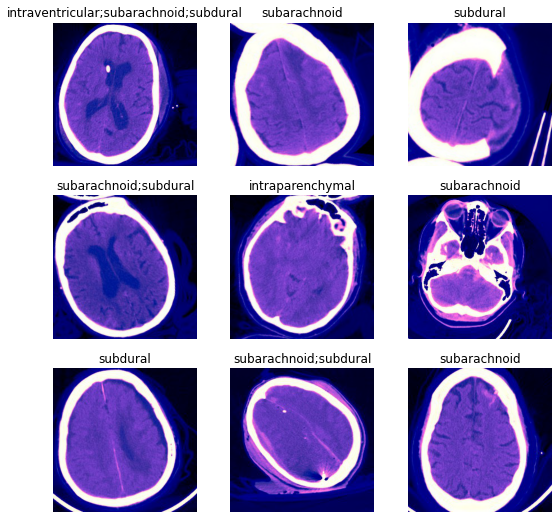

In [23]:
dls.show_batch()

In [24]:
len(dls.train_ds), len(dls.valid_ds), dls.bs


(77633, 19408, 64)

In [25]:
learn = cnn_learner(dls, resnet50,pretrained=False, metrics=partial(accuracy_multi, thresh=0.5), model_dir = '/kaggle')


In [26]:
learn.fine_tune(5, base_lr= 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.520005,0.512554,0.722362,08:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.414739,0.500880,0.751000,10:11
1,0.359299,0.381355,0.842931,10:10
2,0.316655,0.300149,0.872568,10:10
3,0.283437,0.269772,0.887201,10:10
4,0.271046,0.259249,0.892766,10:10


In [27]:
learn.save("/content/cnn_multilabel_RSNA_untrained")

Path('/content/cnn_multilabel_RSNA_untrained.pth')

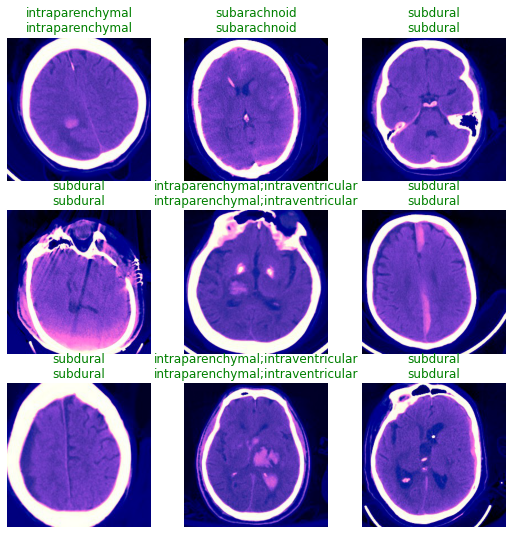

In [28]:
learn.show_results(ds_idx=1)

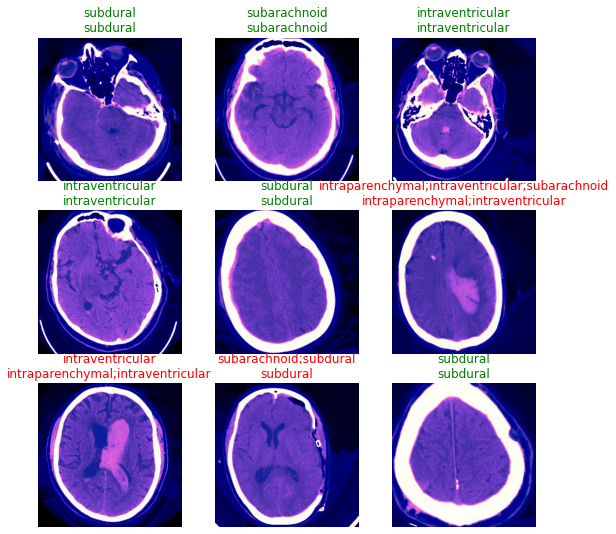

In [30]:
learn.show_results()

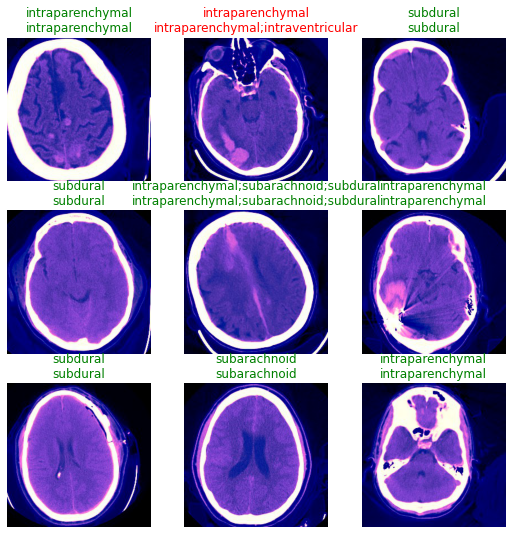

In [31]:
learn.show_results()

In [32]:
@classmethod
def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
    "Construct interpretatio object from a learner"
    if dl is None: dl = learn.dls[ds_idx]
    preds, targs, decoded, losses = learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None)
    return cls(dl, [], preds, targs, decoded, losses)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()